In [1]:
%load_ext autoreload
%autoreload 2

import galsim
import numpy as np
import ngmix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

## Try the Power Spectrum PSFs

In [2]:
from des_psf import DESPSF

SCALE = 0.25

In [3]:
psf = DESPSF(np.random.RandomState(seed=200), 160, SCALE, trunc=200)

In [4]:
ng = 5

gs = 160 / ng
dg = (gs - 1)/2
objs = []
robjs = []
cen = (160 - 1) / 2
g2s = []
g1s = []
fwhms = []
first_psf = None
for i in range(ng):
    for j in range(ng):
        row = i * gs + dg
        col = j * gs + dg
        _psf = psf.getPSF(galsim.PositionD(x=col+1, y=row+1))
        if first_psf is None:
            first_psf = _psf
        _psf_im = _psf.drawImage(nx=33, ny=33, scale=SCALE)
        moms = galsim.hsm.FindAdaptiveMom(_psf_im)
        g1s.append(moms.observed_shape.g1)
        g2s.append(moms.observed_shape.g2)
        fwhms.append(_psf_im.calculateFWHM())
        objs.append(galsim.Convolve(galsim.Gaussian(fwhm=1.0).shift(
            (col-cen) * SCALE, (row-cen) * SCALE), _psf))
        robjs.append(galsim.Convolve(galsim.Gaussian(fwhm=1.0).shift(
            (col-cen) * SCALE, (row-cen) * SCALE), first_psf))
        
g1s = np.array(g1s).reshape(ng, ng)
g2s = np.array(g2s).reshape(ng, ng)
fwhms = np.array(fwhms).reshape(ng, ng)

xt = ["%0.1f" % (i * gs + dg) for i in range(ng)]

In [5]:
im = galsim.Sum(objs).drawImage(nx=160, ny=160, scale=SCALE).array
rim = galsim.Sum(robjs).drawImage(nx=160, ny=160, scale=SCALE).array

Text(0.5, 1.0, 'PSF G2')

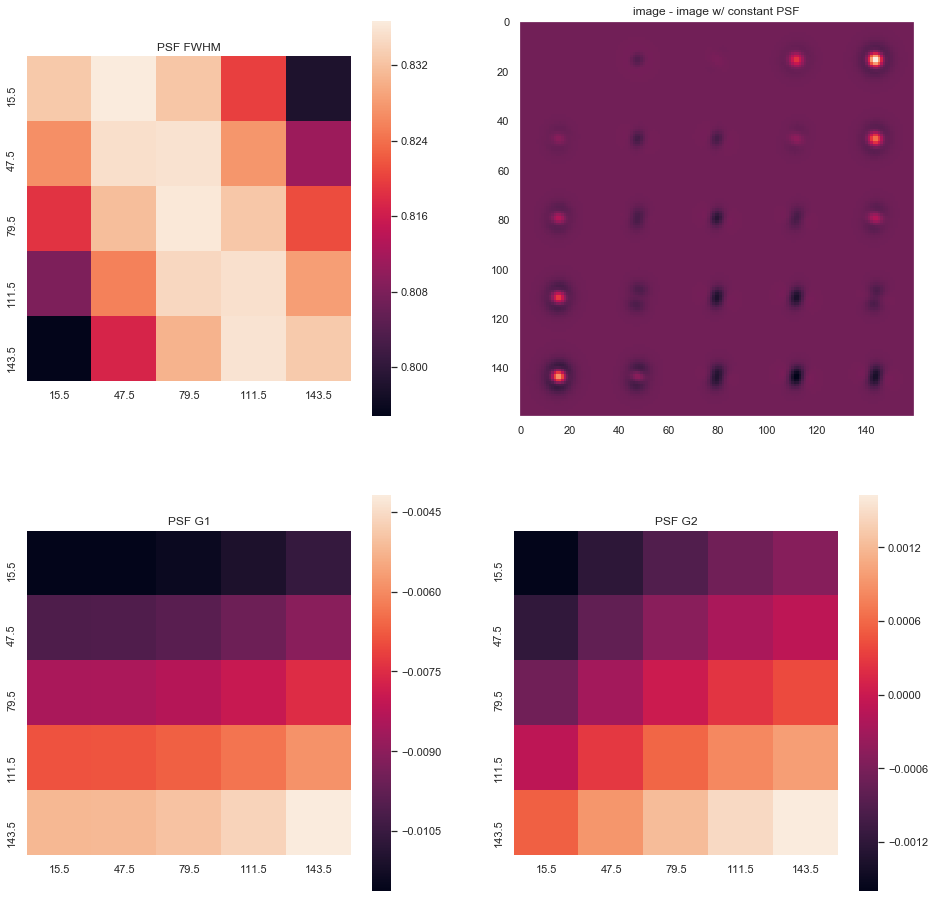

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

ax = axs[0, 0]
sns.heatmap(fwhms, ax=ax, square=True, xticklabels=xt, yticklabels=xt)
ax.set_title('PSF FWHM')

ax = axs[0, 1]
ax.imshow(im - rim)
ax.grid(False)
ax.set_title('image - image w/ constant PSF')

ax = axs[1, 0]
sns.heatmap(g1s, ax=ax, square=True, xticklabels=xt, yticklabels=xt)
ax.set_title('PSF G1')

ax = axs[1, 1]
sns.heatmap(g2s, ax=ax, square=True, xticklabels=xt, yticklabels=xt)
ax.set_title('PSF G2')

In [7]:
def psf_model(row, col):
    return psf.getPSF(
        galsim.PositionD(x=col+1, y=row+1)).drawImage(
        nx=33, ny=33, scale=SCALE).array

In [9]:
from psf_homogenizer import PSFHomogenizer

n_kern = 11
hpsf = PSFHomogenizer(
    psf_model, 160, 10, 
    kernel_size=n_kern, 
    super_sampling_factor=2, 
    dilation_fudge=1.025)
hpsf.solve_for_kernel()

     singular covariance
    pars at singular: 3.64e-07  3.86e-09    -0.038   -0.0135     0.863     0.955 
     singular covariance
    pars at singular: 4.08e-09  1.53e-06   -0.0742   -0.0208      1.68     0.945 


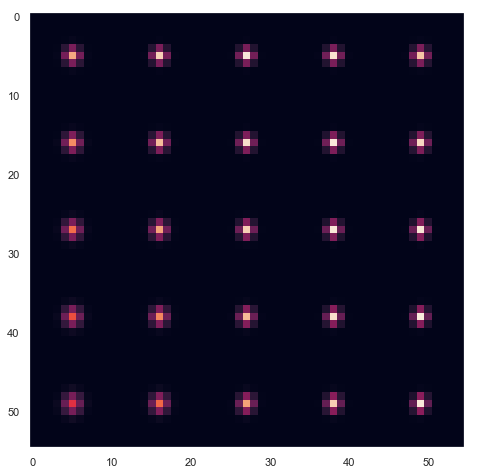

In [10]:
# plot the kernels
gsi = int(gs)
kern = np.zeros((n_kern * ng, n_kern * ng))
for i in range(ng):
    for j in range(ng):
        _is = i * gsi
        _js = j * gsi
        prof = hpsf.get_kernel(_is, _js)
        kern[
            i*n_kern:i*n_kern+n_kern, 
            j*n_kern:j*n_kern+n_kern] = prof        

plt.figure(figsize=(8, 8))
plt.imshow(kern)
plt.gca().grid(False)

In [11]:
%%time

imh = hpsf.apply_kernel(im)

CPU times: user 42.9 s, sys: 463 ms, total: 43.3 s
Wall time: 45.6 s


In [12]:
# make a residual image as if the middle was the correct profile
gsi = int(gs)
_is = ((ng - 1)//2) * gsi
_js = _is
prof = imh[_is:_is+gsi, _js:_js+gsi]
imh_true = np.zeros_like(imh)
for i in range(ng):
    for j in range(ng):
        _is = i * gsi
        _js = j * gsi
        imh_true[_is:_is+gsi, _js:_js+gsi] = prof
        
gsi = int(gs)
_is = ((ng - 1)//2) * gsi
_js = _is
prof = im[_is:_is+gsi, _js:_js+gsi]
im_true = np.zeros_like(imh)
for i in range(ng):
    for j in range(ng):
        _is = i * gsi
        _js = j * gsi
        im_true[_is:_is+gsi, _js:_js+gsi] = prof

Text(0.5, 1.0, 'image')

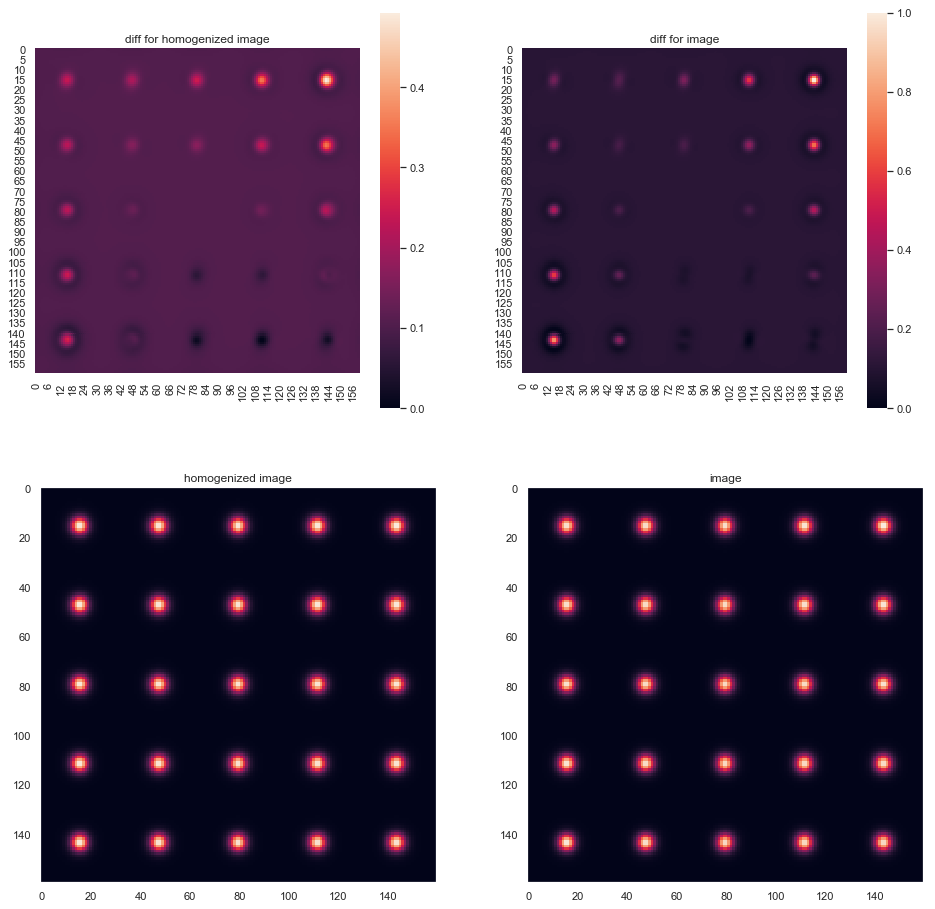

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

vmin = np.min((im - im_true))
vmax = np.max((im - im_true))

pq = (im - im_true)
pq = (pq - vmin)/(vmax - vmin)

pqh = (imh - imh_true)
pqh = (pqh - vmin)/(vmax - vmin)
pqh -= np.min(pqh)

ax = axs[0, 0]
sns.heatmap(pqh, ax=ax, square=True)
ax.set_title('diff for homogenized image')

ax = axs[0, 1]
sns.heatmap(pq, ax=ax, square=True, vmin=0, vmax=1)
ax.set_title('diff for image')

ax = axs[1, 0]
ax.imshow(imh)
ax.grid(False)
ax.set_title('homogenized image')

ax = axs[1, 1]
ax.imshow(im)
ax.grid(False)
ax.set_title('image')